In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from iobs.layers import IOBLayer
from iobs.models import BaseAE
from torch import nn, optim
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from typing import Tuple

In [112]:
def plot_dynamic_spectra(dynamic_spectra, title="Dynamic Spectra"):
    """
    Plot a dynamic spectrum with horizontal time axis and reversed frequency axis.

    Parameters:
        dynamic_spectra (numpy.ndarray): The dynamic spectrum to plot.
        title (str): The title for the plot (default is "Dynamic Spectra").

    Returns:
        None
    """
    # Calculate the time step based on the number of time samples
    num_time_samples = dynamic_spectra.shape[0]
    time_step = 0.0000256  # Default time step in seconds

    # Calculate the extent based on the number of frequency channels
    extent = [0, num_time_samples * time_step * 1000, 1208, 1700]

    plt.figure(figsize=(10, 6))
    plt.imshow(dynamic_spectra.T, aspect="auto", cmap="viridis", extent=extent)
    plt.xlabel("Time (ms)", size=14)
    plt.ylabel("Frequency (MHz)", size=14)
    plt.colorbar()
    plt.title(title, size=16)
    plt.show()

In [113]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [142]:
# directories = [
#     "noiseless_1000_simple_narrow",
#     "noiseless_1000_simple_broad",
#     "noiseless_1000_simple_middle",
#     "noiseless_1000_simple_broad_narrow_time",
#     "noiseless_1000_scattered",
#     "noiseless_1000_complex",
#     "noiseless_1000_drifting",
# ]

# Define the directories containing the data for different classes
directories = [
    "1000_Constant_SNR_simple_narrow",
    "1000_Constant_SNR_simple_broad",
    "1000_Constant_SNR_simulated_scattered",
    "1000_Constant_SNR_complex",
    "1000_Constant_SNR_drifting",
]

# Define the directories containing the data for different classes
# directories = [
#     "1000_Constant_SNR_simple_narrow_res",
#     "1000_Constant_SNR_simple_broad_res",
#     "1000_Constant_SNR_simulated_scattered_res",
#     "1000_Constant_SNR_complex_res",
#     "1000_Constant_SNR_drifting_res",
# ]

# Initialize lists to store data and corresponding labels
data = []
labels = []

# Iterate over each class directory
for class_idx, directory in enumerate(directories):
    # Construct the full path to the data directory
    data_dir = f"data/{directory}"
    data_per_directory = []

    # Iterate over each file in the directory
    for filename in os.listdir(data_dir):
        if filename.endswith(".npy"):
            # Load the dynamic spectra with pulse from the file
            dynamic_spectra_w_pulse = np.load(os.path.join(data_dir, filename))
            
            # Rebin the spectrum to a smaller size
            rebinned_spectrum = rebin(dynamic_spectra_w_pulse, (int(1024/4), int(512/4)))
            
            # Ensure no zero values in the rebinned spectrum to avoid issues during processing
            if np.any(rebinned_spectrum == 0.0):
                rebinned_spectrum[rebinned_spectrum == 0] = 0.0001
            
            # Append the rebinned spectrum to the list of data for this class
            data_per_directory.append(rebinned_spectrum)
            
            # Append the class index as the label for this data point
            labels.append(class_idx)

    # Limit the number of data points per class
    data_per_directory = np.array(data_per_directory)[:1000]
    
    # Append the data for this class to the overall data list
    data.append(data_per_directory)

# Concatenate the data and labels for all classes
data = np.concatenate(data, axis=0)
labels = np.array(labels)

# Split the data into training and testing sets while maintaining class balance
test_size = 0.2
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_size, shuffle=True, random_state=42)


In [143]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

print(len(labels_test))

cuda
1000


## Prep data for Network

In [116]:
# Convert data to PyTorch tensors
data_train_tensor = torch.Tensor(data_train[:, None, :])
data_test_tensor = torch.Tensor(data_test[:, None, :])

# Convert labels to PyTorch tensors
labels_train_tensor = torch.LongTensor(labels_train)
labels_test_tensor = torch.LongTensor(labels_test)

# Create weights for training data
train_weights = np.zeros_like(data_train_tensor)

# Calculate the minimum absolute value for every spectrum and add it to the weights list
for i, spectra in enumerate(data_train_tensor):
    min_abs_value = torch.min(torch.abs(spectra))
    train_weights[i, :, :, :]=(torch.log((torch.abs(spectra) / min_abs_value.item())) + 0.1)

# Convert weights to pytorch tensor
train_weights_tensor = torch.tensor(train_weights)

# Create weights for test data
test_weights = np.zeros_like(data_test_tensor)

# Calculate the minimum absolute value for every spectrum and add it to the weights list
for i, spectra in enumerate(data_test_tensor):
    min_abs_value = torch.min(torch.abs(spectra))
    test_weights[i, :, :, :]=(torch.log((torch.abs(spectra) / min_abs_value.item())) + 0.1)

# Convert weights to pytorch tensor
test_weights_tensor = torch.tensor(test_weights)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(data_train_tensor, train_weights_tensor, labels_train_tensor)
test_dataset = TensorDataset(data_test_tensor, test_weights_tensor, labels_test_tensor)

batch_size = 16  # Adjust as needed
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Define my own Loss Function to give more importance to signal

In [117]:
# Define weighted loss function to give more strength to signal
class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, inputs, targets, weights):
        return torch.sum(((inputs - targets) ** 2 ) * weights)

## Information Ordered Bottleneck With CNN

In [118]:
class BaseAE_noUnflatt(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 bottleneck: IOBLayer
                 ) -> None:
        """Basic autoencoder model with support for IOB forward functions

        Args:
            encoder (nn.Module): An encoder module which outputs a dense layer
            decoder (nn.Module): A decoder module which accepts a dense layer
            bottleneck (nn.Module): An IOBLayer module
        """
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.bottleneck = bottleneck
        self.latent_dim = bottleneck.num_features

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        """Usual forward autoencoding with a fully-open bottleneck."""
        code = self.encoder(features)
        reconstructed = self.decoder(code)
        return reconstructed

    def forward_mask(self, features: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """Apply a custom mask to the latent vector. Mask must be of shape
        (self.latent_dim) or (batch_size, self.latent_dim).
        """
        code = self.encoder(features)
        code = self.bottleneck.forward_mask(code, mask)
        reconstructed = self.decoder(code)
        return reconstructed

    def forward_neck(self, features: torch.Tensor, n_open: int) -> torch.Tensor:
        """Forward autoencoding with a bottleneck of width n_open."""
        code = self.encoder(features)
        code = self.bottleneck.forward_neck(code, n_open)
        reconstructed = self.decoder(code)
        return reconstructed

    def forward_all(self, features: torch.Tensor) -> torch.Tensor:
        """Pass through the batch for all possible bottleneck widths.
        Creates a new axis in the output batch to store different bottleneck
        configurations. For example, if the input is of shape
        (batch_size, *in_shape), then this function will output a Tensor
        of shape (batch_size, self.latent_dim+1, *in_shape), where the first
        index of the second axis is equivalent to n_open=0 and the last
        index is equivalent to n_open=num_features.
        """
        batch_size = len(features)
        code = self.encoder(features)
        
        ## shape  = bathc_size, dim+1 , dim
        code = self.bottleneck.forward_all(code)
        #print(code.shape)
        
        ## This originally collapse  batch_size * dim+1
        #code = torch.flatten(code, end_dim=1)
        code = code.view(code.size(0)*code.size(1), code.size(2))
        #print(code.shape)
        reconstructed = self.decoder(code)
        
        ## This will go back to batchsize, dim+1, n_filters, outsize outsize
#         reconstructed = torch.unflatten(
#             reconstructed, dim=0, sizes=(batch_size, -1))
        
        reconstructed = reconstructed.view(batch_size,self.latent_dim+1,*features.shape[1:])
        #print(reconstructed.shape)
        return reconstructed

In [119]:
# define the NN architecture
class EncoderCNN(nn.Module):
    def __init__(self, embedding_size=24, num_filters=8):
        super(EncoderCNN, self).__init__()
        ## encoder layers ##
        # 
        self.conv1 = nn.Conv2d(1, num_filters, 3, padding=1)  
        # 
        self.conv2 = nn.Conv2d(num_filters, num_filters, 3, padding=1)
        
        self.conv3 = nn.Conv2d(num_filters, num_filters, 3, padding=1)
        
        #self.conv4 = nn.Conv2d(num_filters, num_filters, 3, padding=1)
        
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        
        
        # compute the flattened size after convolutions
        
        ## automated-computation would be (input_size_x / (2**number_of_conv_layers) * (input_size_y / (2**numb_conv_layers))
        
        self.shape_before_flattening = (num_filters,32, 16)
        flattened_size = num_filters * 32 * 16 #
        # define fully connected layer to create embeddings
        
        self.embedding_size = embedding_size
        
        self.lin1 = nn.Linear(flattened_size, embedding_size)
        
        

    def forward(self, x):
        ## encode ##
        # 
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        #x = self.pool(x)
        #x = F.relu(self.conv4(x))
        
        x = self.pool(x)  # compressed representation
        
        # flatten the tensor
        x = x.view(x.size(0), -1)
        
        z = self.lin1(x)
        
                
        return z


# define the NN architecture
class DecoderCNN(nn.Module):
    def __init__(self, embedding_size=24, num_filters=8):
        super(DecoderCNN, self).__init__()
       
        self.shape_before_flattening = (num_filters,32, 16)
        flattened_size = num_filters * 32 * 16 #
        # define fully connected layer to create embeddings
        
        self.embedding_size = embedding_size
        
        
        self.lin2 = nn.Linear(embedding_size, flattened_size)
        # store the shape before flattening
        self.reshape_dim = self.shape_before_flattening
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(num_filters, num_filters, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(num_filters, num_filters, 2, stride=2)
        #self.t_conv3 = nn.ConvTranspose2d(num_filters, num_filters, 2, stride=2)
        self.t_conv4 = nn.ConvTranspose2d(num_filters, 1, 2, stride=2)

    def forward(self, x):
        
        x = self.lin2(x)
        x = x.view(x.size(0), *self.reshape_dim)
        #print(x.shape)
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        #print(x.shape)
        #x = F.relu(self.t_conv3(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv4(x))
                
        return x

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print('Device:', device)

num_workers = 0
# how many samples per batch to load
batch_size = 40

# build a simple autoencoder model
model = BaseAE_noUnflatt(
    encoder=EncoderCNN(25).to(device),
    decoder=DecoderCNN(25).to(device),
    bottleneck=IOBLayer(25, device=device)
)

# define a criterion for log-likelihood maximization
criterion = nn.MSELoss()

def lossfn(model, batch_features):
    """Loss function for averaging loss over all bottleneck widths evenly"""
    outputs = model.forward_all(batch_features)
    #print(outputs.shape)
    target = batch_features.unsqueeze(1).expand(*(outputs.shape))
    #print(target.shape)
    loss = criterion(outputs, target)
    return loss

# training
max_epochs = 100
lr = 0.001
print_every = 1

# early stopping
min_change = 0.0001
patience = 20

optimizer = optim.Adam(model.parameters(), lr)

trloss_rec = []
valoss_rec = []
wait = 0
min_valoss = np.inf
for epoch in range(max_epochs):
    # train
    trloss = 0
    for batch_features, _, _ in train_loader:
        batch_features = batch_features.float().to(device)
        optimizer.zero_grad()
        batch_loss = lossfn(model, batch_features)
        batch_loss.backward()
        optimizer.step()
        trloss += batch_loss.item()*len(batch_features)
    trloss = trloss / len(data_train)

    # test
    with torch.no_grad():
        valoss = 0
        for batch_features, _, _ in test_loader:
            batch_features = batch_features.float().to(device)
            batch_loss = lossfn(model, batch_features)
            valoss += batch_loss.item()*len(batch_features)
        valoss = valoss / len(data_test)

    # record loss
    trloss_rec.append(trloss)
    valoss_rec.append(valoss)
    if epoch % print_every == 0:
        print(f"epoch : {epoch + 1}/{max_epochs}, "
              f"loss = {trloss:.6f}, val loss = {valoss:.6f}")
    
    # compute early stopping
    if valoss < min_valoss*(1-min_change):
        wait = 0
        min_valoss = valoss
    else:
        wait += 1
    if wait >= patience:
        print(f'Early stopping at epoch {epoch + 1}/{max_epochs}')
        break

Device: cuda
epoch : 1/100, loss = 0.054095, val loss = 0.014479
epoch : 2/100, loss = 0.012451, val loss = 0.009422
epoch : 3/100, loss = 0.005867, val loss = 0.003667
epoch : 4/100, loss = 0.003210, val loss = 0.002833
epoch : 5/100, loss = 0.002841, val loss = 0.003532
epoch : 6/100, loss = 0.002631, val loss = 0.002476
epoch : 7/100, loss = 0.002480, val loss = 0.002389
epoch : 8/100, loss = 0.002383, val loss = 0.002314
epoch : 9/100, loss = 0.002259, val loss = 0.002159
epoch : 10/100, loss = 0.002749, val loss = 0.004268
epoch : 11/100, loss = 0.004256, val loss = 0.004122
epoch : 12/100, loss = 0.003974, val loss = 0.003708
epoch : 13/100, loss = 0.003492, val loss = 0.003153
epoch : 14/100, loss = 0.002904, val loss = 0.002610
epoch : 15/100, loss = 0.002487, val loss = 0.002322
epoch : 16/100, loss = 0.002285, val loss = 0.002170
epoch : 17/100, loss = 0.002056, val loss = 0.001929
epoch : 18/100, loss = 0.001935, val loss = 0.001886
epoch : 19/100, loss = 0.001898, val loss 

## Train the network

## Visualize reconstruction

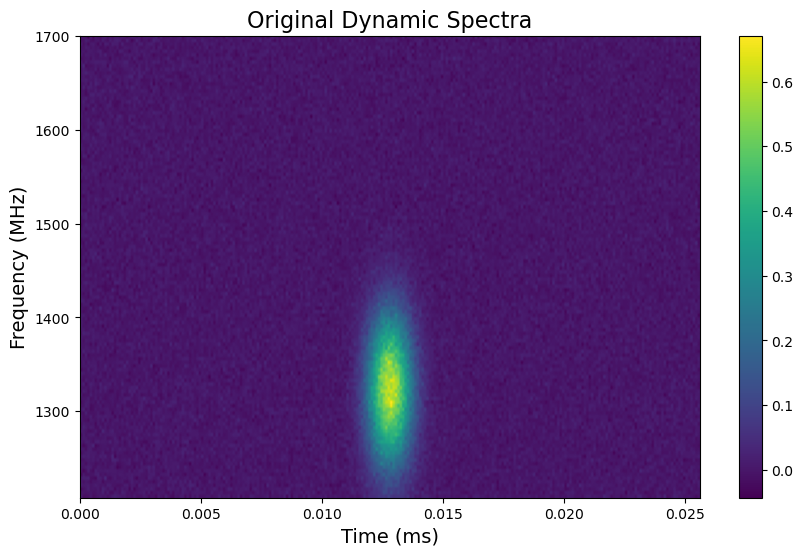

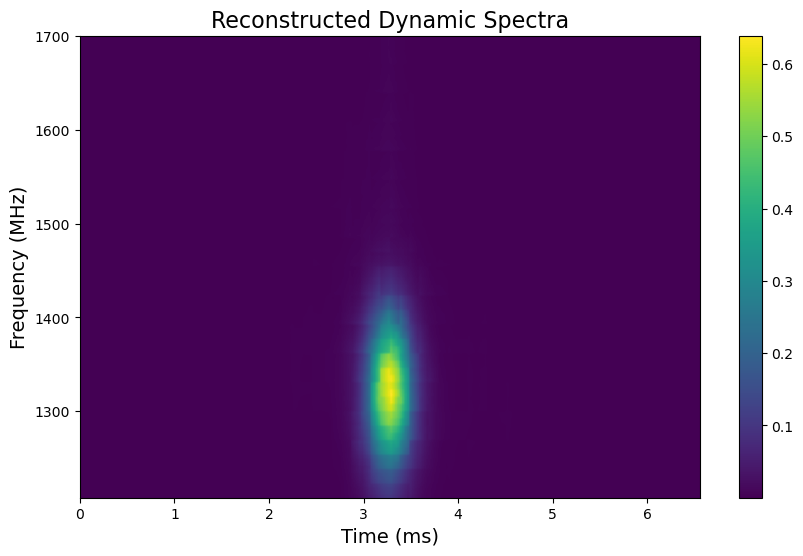

In [54]:
# Assuming data_test_tensor is of shape [batch_size, channels, height, width]
batch_size, channels, height, width = data_test_tensor.shape
# Reshape data_test_tensor to match the expected input shape of the model
inputs = data_test_tensor.to(device)  # Move data to the GPU

# Testing the autoencoder
model.eval()
with torch.no_grad():
    reconstructed = model(inputs)  # Unpack the output tuple to get the reconstructed tensor

idx = 300

# Convert tensors to numpy arrays for plotting
original_np = data_test_tensor[idx].cpu().numpy()  # Move data back to CPU for plotting
reconstructed_np = reconstructed[idx, 0].cpu().numpy()  # Move data back to CPU for plotting

# Visualize original and reconstructed data
plot_dynamic_spectra(original_np, title="Original Dynamic Spectra")
plot_dynamic_spectra(reconstructed_np, title="Reconstructed Dynamic Spectra")

1000
[0 1 2 3 4]


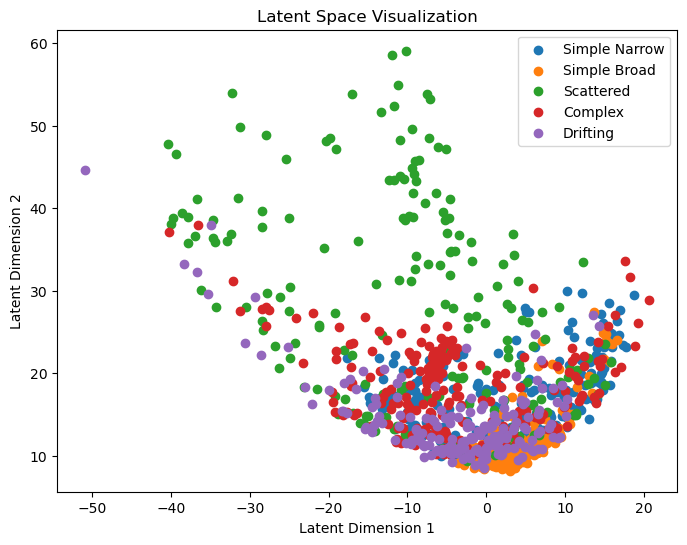

In [157]:
# Initialize lists to store encoded representations for different bottleneck widths
encoded_representations_all = []
burst_labels_all = []  # Initialize list to store burst labels

# Testing the autoencoder batch-wise
model.eval()

with torch.no_grad():
    for batch_features, _, labels in test_loader:
        batch_features = batch_features.to(device)  # Move input data to the GPU
        # Initialize a list to store encoded representations for the current batch
        encoded_representations_batch = []
        # Pass the batch through the model for different bottleneck widths
        for width in range(5):
            # Pass the batch through the encoder for the current bottleneck width
            encoded = model.encoder(batch_features)[:, :width+1].detach().cpu().numpy()
            # Append the encoded representations for the current bottleneck width
            encoded_representations_batch.append(encoded)
        # Concatenate encoded representations for the current batch along a new axis representing the bottleneck width
        encoded_representations_batch = np.concatenate(encoded_representations_batch, axis=1)
        # Append the encoded representations for the current batch to the list
        encoded_representations_all.append(encoded_representations_batch)
        burst_labels_all.extend(labels)

# Concatenate encoded representations for different batches
encoded_representations_all = np.concatenate(encoded_representations_all, axis=0)

# Define burst categories and colors
burst_categories = np.unique(labels_test)
num_categories = len(burst_categories)

print(len(burst_labels_all))

# Define labels for each directory
burst_labels = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

print(burst_categories)

# Now you have the encoded representations for all the test data and different bottleneck widths
# Select the encoded representations for bottleneck width of 2
encoded_representations_width_2 = encoded_representations_all[:, :5]

# Visualize the encoded representations in a 2D space
plt.figure(figsize=(8, 6))
for i, category in enumerate(burst_categories):
    indices = np.where(np.array(burst_labels_all) == category)[0]
    plt.scatter(encoded_representations_width_2[indices, 2], encoded_representations_width_2[indices, 3], label=f'{burst_labels[i]}')

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.legend()
plt.show()



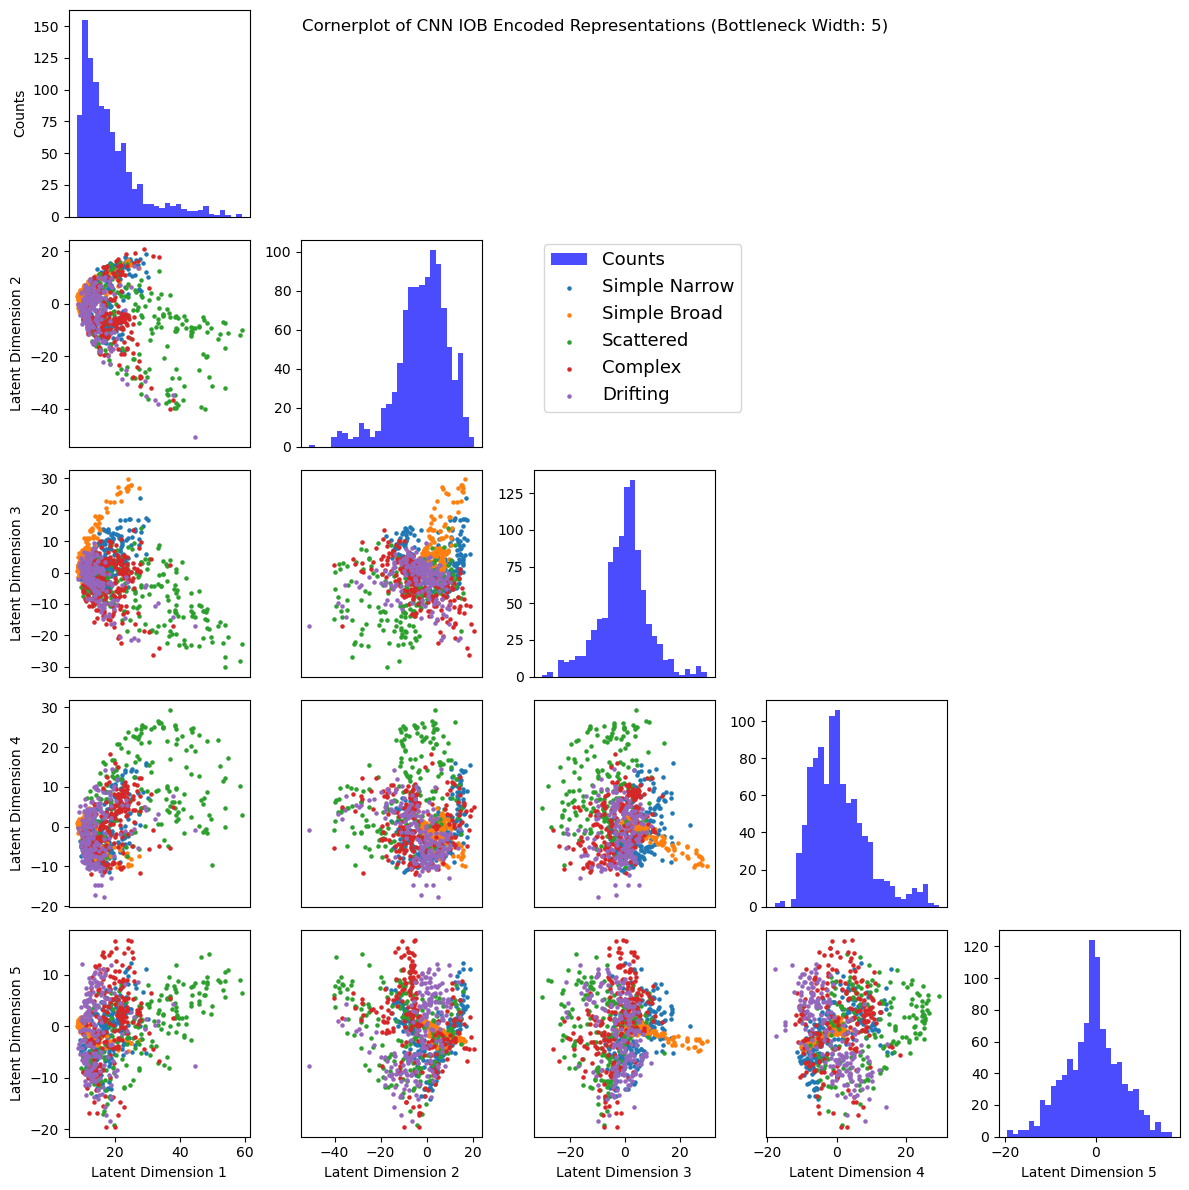

In [164]:
# Initialize lists to store encoded representations for different bottleneck widths
encoded_representations_all = []
burst_labels_all = []  # Initialize list to store burst labels

# Testing the autoencoder batch-wise
model.eval()

with torch.no_grad():
    for batch_features, _, labels in test_loader:
        batch_features = batch_features.to(device)  # Move input data to the GPU
        # Initialize a list to store encoded representations for the current batch
        encoded_representations_batch = []
        # Pass the batch through the model for bottleneck width of 5
        encoded = model.encoder(batch_features)[:, :5].detach().cpu().numpy()
        # Append the encoded representations for the current batch
        encoded_representations_all.append(encoded)
        burst_labels_all.extend(labels)

# Concatenate encoded representations for different batches
encoded_representations_all = np.concatenate(encoded_representations_all, axis=0)

# Define burst categories and colors
burst_categories = np.unique(burst_labels_all)
num_categories = len(burst_categories)

# Define labels for each directory
burst_labels = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

# Create labels for each component
labels = [f"Latent Dimension {i+1}" for i in range(encoded_representations_all.shape[1])]

# Create a square grid of subplots
fig, axes = plt.subplots(encoded_representations_all.shape[1], encoded_representations_all.shape[1], figsize=(12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Plot histograms on the diagonal
for i in range(encoded_representations_all.shape[1]):
    axes[i, i].hist(encoded_representations_all[:, i], bins=30, color='blue', alpha=0.7)
    if i == 0:
        axes[i, i].set_ylabel('Counts')
    if i == encoded_representations_all.shape[1] - 1:
        axes[i, i].set_xlabel(labels[i])
        axes[i, i].tick_params(axis='x', bottom=True, top=False)
    else:
        axes[i, i].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
        

# Plot scatter plots on the off-diagonal
for i in range(encoded_representations_all.shape[1]):
    for j in range(i + 1, encoded_representations_all.shape[1]):
        for k, category in enumerate(burst_categories):
            indices = np.where(np.array(burst_labels_all) == category)[0]
            axes[j, i].scatter(encoded_representations_all[indices, i], encoded_representations_all[indices, j], label=burst_labels[k], s=5)
        axes[i, j].set_axis_off()
        # Adjust y-axis labels and ticks
        if j == encoded_representations_all.shape[1] - 1:
            axes[j, i].set_xlabel(labels[i])
            axes[j, i].tick_params(axis='x', bottom=True, top=False)
        else:
            axes[j, i].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
        if i == 0:
            axes[j, i].set_ylabel(labels[j])
            axes[j, i].tick_params(axis='y', left=True, right=False)
        else:
            axes[j, i].tick_params(axis='y', left=False, right=False, labelleft=False)
            
# Add legend outside the subplots
fig.legend([
    "Counts",
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
],loc='upper left', bbox_to_anchor=(0.45, 0.8), fontsize='13')

# Adjust layout for better visualization
plt.tight_layout()

plt.suptitle("Cornerplot of CNN IOB Encoded Representations (Bottleneck Width: 5)")

# Show the plot
plt.show()



## Look at Reconstruction Error as function of Bottleneck width

/home/dkuiper/.conda/envs/FRBakery/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


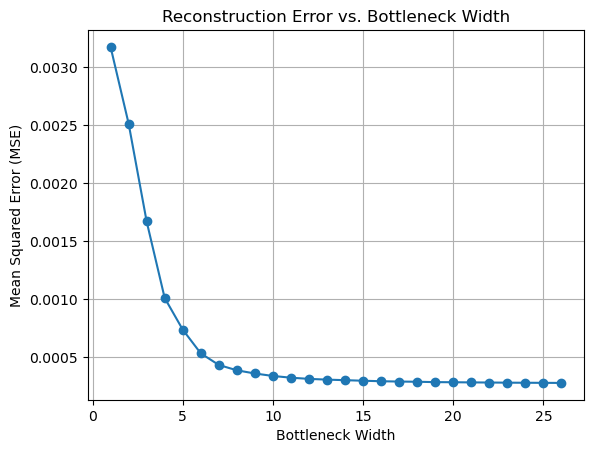

In [59]:
# Initialize lists to store reconstruction errors and bottleneck sizes
reconstruction_errors = []
bottleneck_sizes = []

# Testing the autoencoder batch-wise
model.eval()
reconstructed_all = []

with torch.no_grad():
    for batch_features, _, _ in test_loader:
        batch_features = batch_features.to(device)  # Move input data to the GPU and reshape
        reconstructed_batch = model.forward_all(batch_features).detach().cpu().numpy()  # Forward the batch through the model
        reconstructed_all.append(reconstructed_batch)

# Concatenate reconstructed batches
reconstructed_all = np.concatenate(reconstructed_all, axis=0)

# Iterate over possible bottleneck widths
for width in range(model.latent_dim + 1):
    # Select reconstructed data for the current bottleneck width
    reconstructed = reconstructed_all[:, width]
    
    # Calculate Mean Squared Error (MSE) for the current bottleneck width
    mse = mean_squared_error(data_test.flatten(), reconstructed.flatten())
    
    # Store reconstruction error (MSE) and bottleneck size
    reconstruction_errors.append(mse)
    bottleneck_sizes.append(width + 1) # Smallest Latent Space is 1

# Plot the reconstruction error (MSE) vs. bottleneck width
plt.plot(bottleneck_sizes, reconstruction_errors, marker='o')
plt.xlabel('Bottleneck Width')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Reconstruction Error vs. Bottleneck Width')
plt.grid(True)
plt.show()



/home/dkuiper/.conda/envs/FRBakery/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


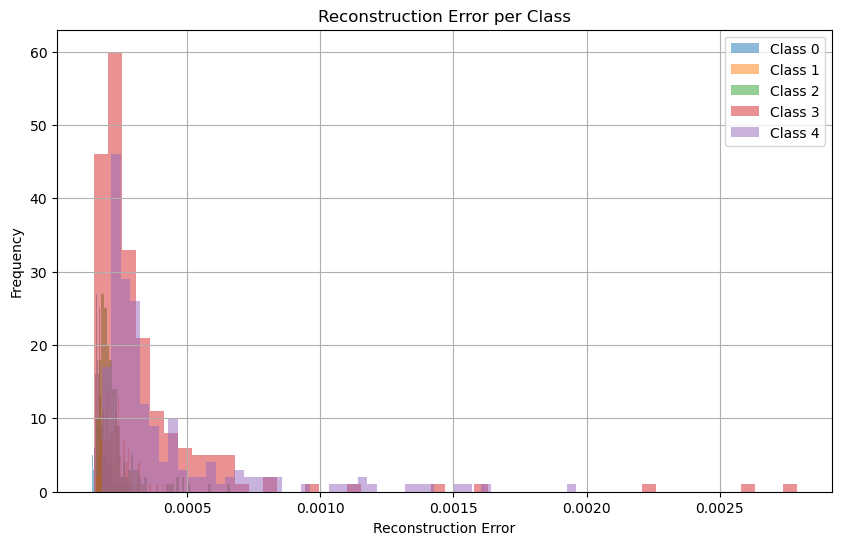

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming num_classes is defined
num_classes = len(np.unique(labels_test))

# Initialize lists to store the reconstruction error per class
reconstruction_errors_per_class = [[] for _ in range(num_classes)]

# Evaluate the autoencoder
model.eval()
with torch.no_grad():
    # Move input data to the GPU
    inputs = data_test_tensor.to(device)  
    
    # Forward pass through the model
    reconstructed = model(inputs)
    
    # Move the reconstructed data to CPU and convert it to a NumPy array
    reconstructed = reconstructed.cpu().numpy()

# Calculate the reconstruction error per class
for class_idx in range(num_classes):
    # Get indices of data points belonging to the current class
    class_indices = np.where(labels_test == class_idx)[0]
    
    # Calculate the reconstruction error for data points of the current class
    for idx in class_indices:
        error = np.mean(np.square(inputs[idx].cpu().numpy() - reconstructed[idx]))
        reconstruction_errors_per_class[class_idx].append(error)

# Plot the reconstruction error per class
plt.figure(figsize=(10, 6))
for class_idx in range(num_classes):
    plt.hist(reconstruction_errors_per_class[class_idx], bins=50, alpha=0.5, label=f'Class {class_idx}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error per Class')
plt.legend()
plt.grid(True)
plt.show()


## Look at Reconstruction Error as a function of Bottleneck size including Different Classes

In [69]:
# Initialize lists to store reconstruction errors per label and bottleneck sizes
reconstruction_errors_per_label = {label: [] for label in set(labels_test)}
reconstruction_errors = []
bottleneck_sizes = []

# Testing the autoencoder batch-wise
model.eval()
reconstructed_all = []

with torch.no_grad():
    for batch_data, _, batch_labels in test_loader:  # Extract only batch_data and batch_labels
        batch_data = batch_data.to(device)  # Move input data to the GPU and reshape
        reconstructed_batch = model.forward_all(batch_data).detach().cpu().numpy()  # Forward the batch through the model
        reconstructed_all.append(reconstructed_batch)

# Concatenate reconstructed batches
reconstructed_all = np.concatenate(reconstructed_all, axis=0)

# Iterate over possible bottleneck widths
for width in range(model.latent_dim + 1):
    # Select reconstructed data for the current bottleneck width
    reconstructed = reconstructed_all[:, width]

    print(reconstructed.shape)
    
    # Calculate Mean Squared Error (MSE) for the current bottleneck width
    mse = mean_squared_error(data_test.flatten(), reconstructed.flatten())
    
    # Store reconstruction error (MSE) and bottleneck size
    reconstruction_errors.append(mse)

# Iterate over possible bottleneck widths
for width in range(model.latent_dim + 1):
    # Iterate over each label
    for label in set(labels_test):
        # Select reconstructed data for the current bottleneck width and label
        reconstructed = reconstructed_all[labels_test == label, width]

        # Calculate Mean Squared Error (MSE) for the current bottleneck width and label
        mse = mean_squared_error(data_test[labels_test == label].flatten(), reconstructed.flatten())

        # Store reconstruction error (MSE) for the current label and bottleneck size
        reconstruction_errors_per_label[label].append(mse)

    # Store bottleneck size
    bottleneck_sizes.append(width + 1)  # Smallest Latent Space is 1

/home/dkuiper/.conda/envs/FRBakery/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)
(1000, 1, 256, 128)


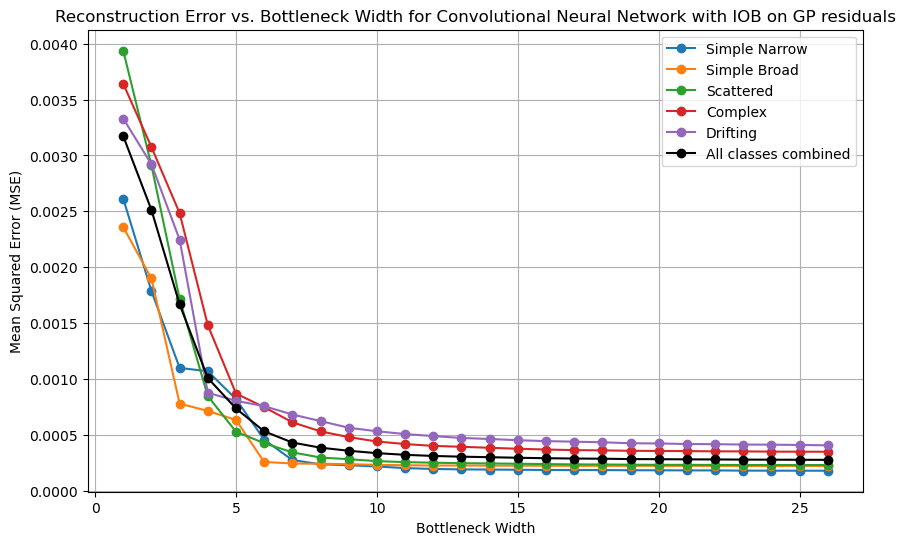

In [58]:
# Define labels for each directory
burst_labels = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

# Plot the reconstruction error (MSE) vs. bottleneck width for each label
plt.figure(figsize=(10, 6))
for idx, (label, errors) in enumerate(reconstruction_errors_per_label.items()):
    plt.plot(bottleneck_sizes, errors, marker='o', label=f'{burst_labels[label]}')

plt.plot(bottleneck_sizes, reconstruction_errors, marker='o', color='black', label='All classes combined')

plt.xlabel('Bottleneck Width')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Reconstruction Error vs. Bottleneck Width for Convolutional Neural Network with IOB on GP residuals')
plt.legend()
plt.grid(True)
plt.show()

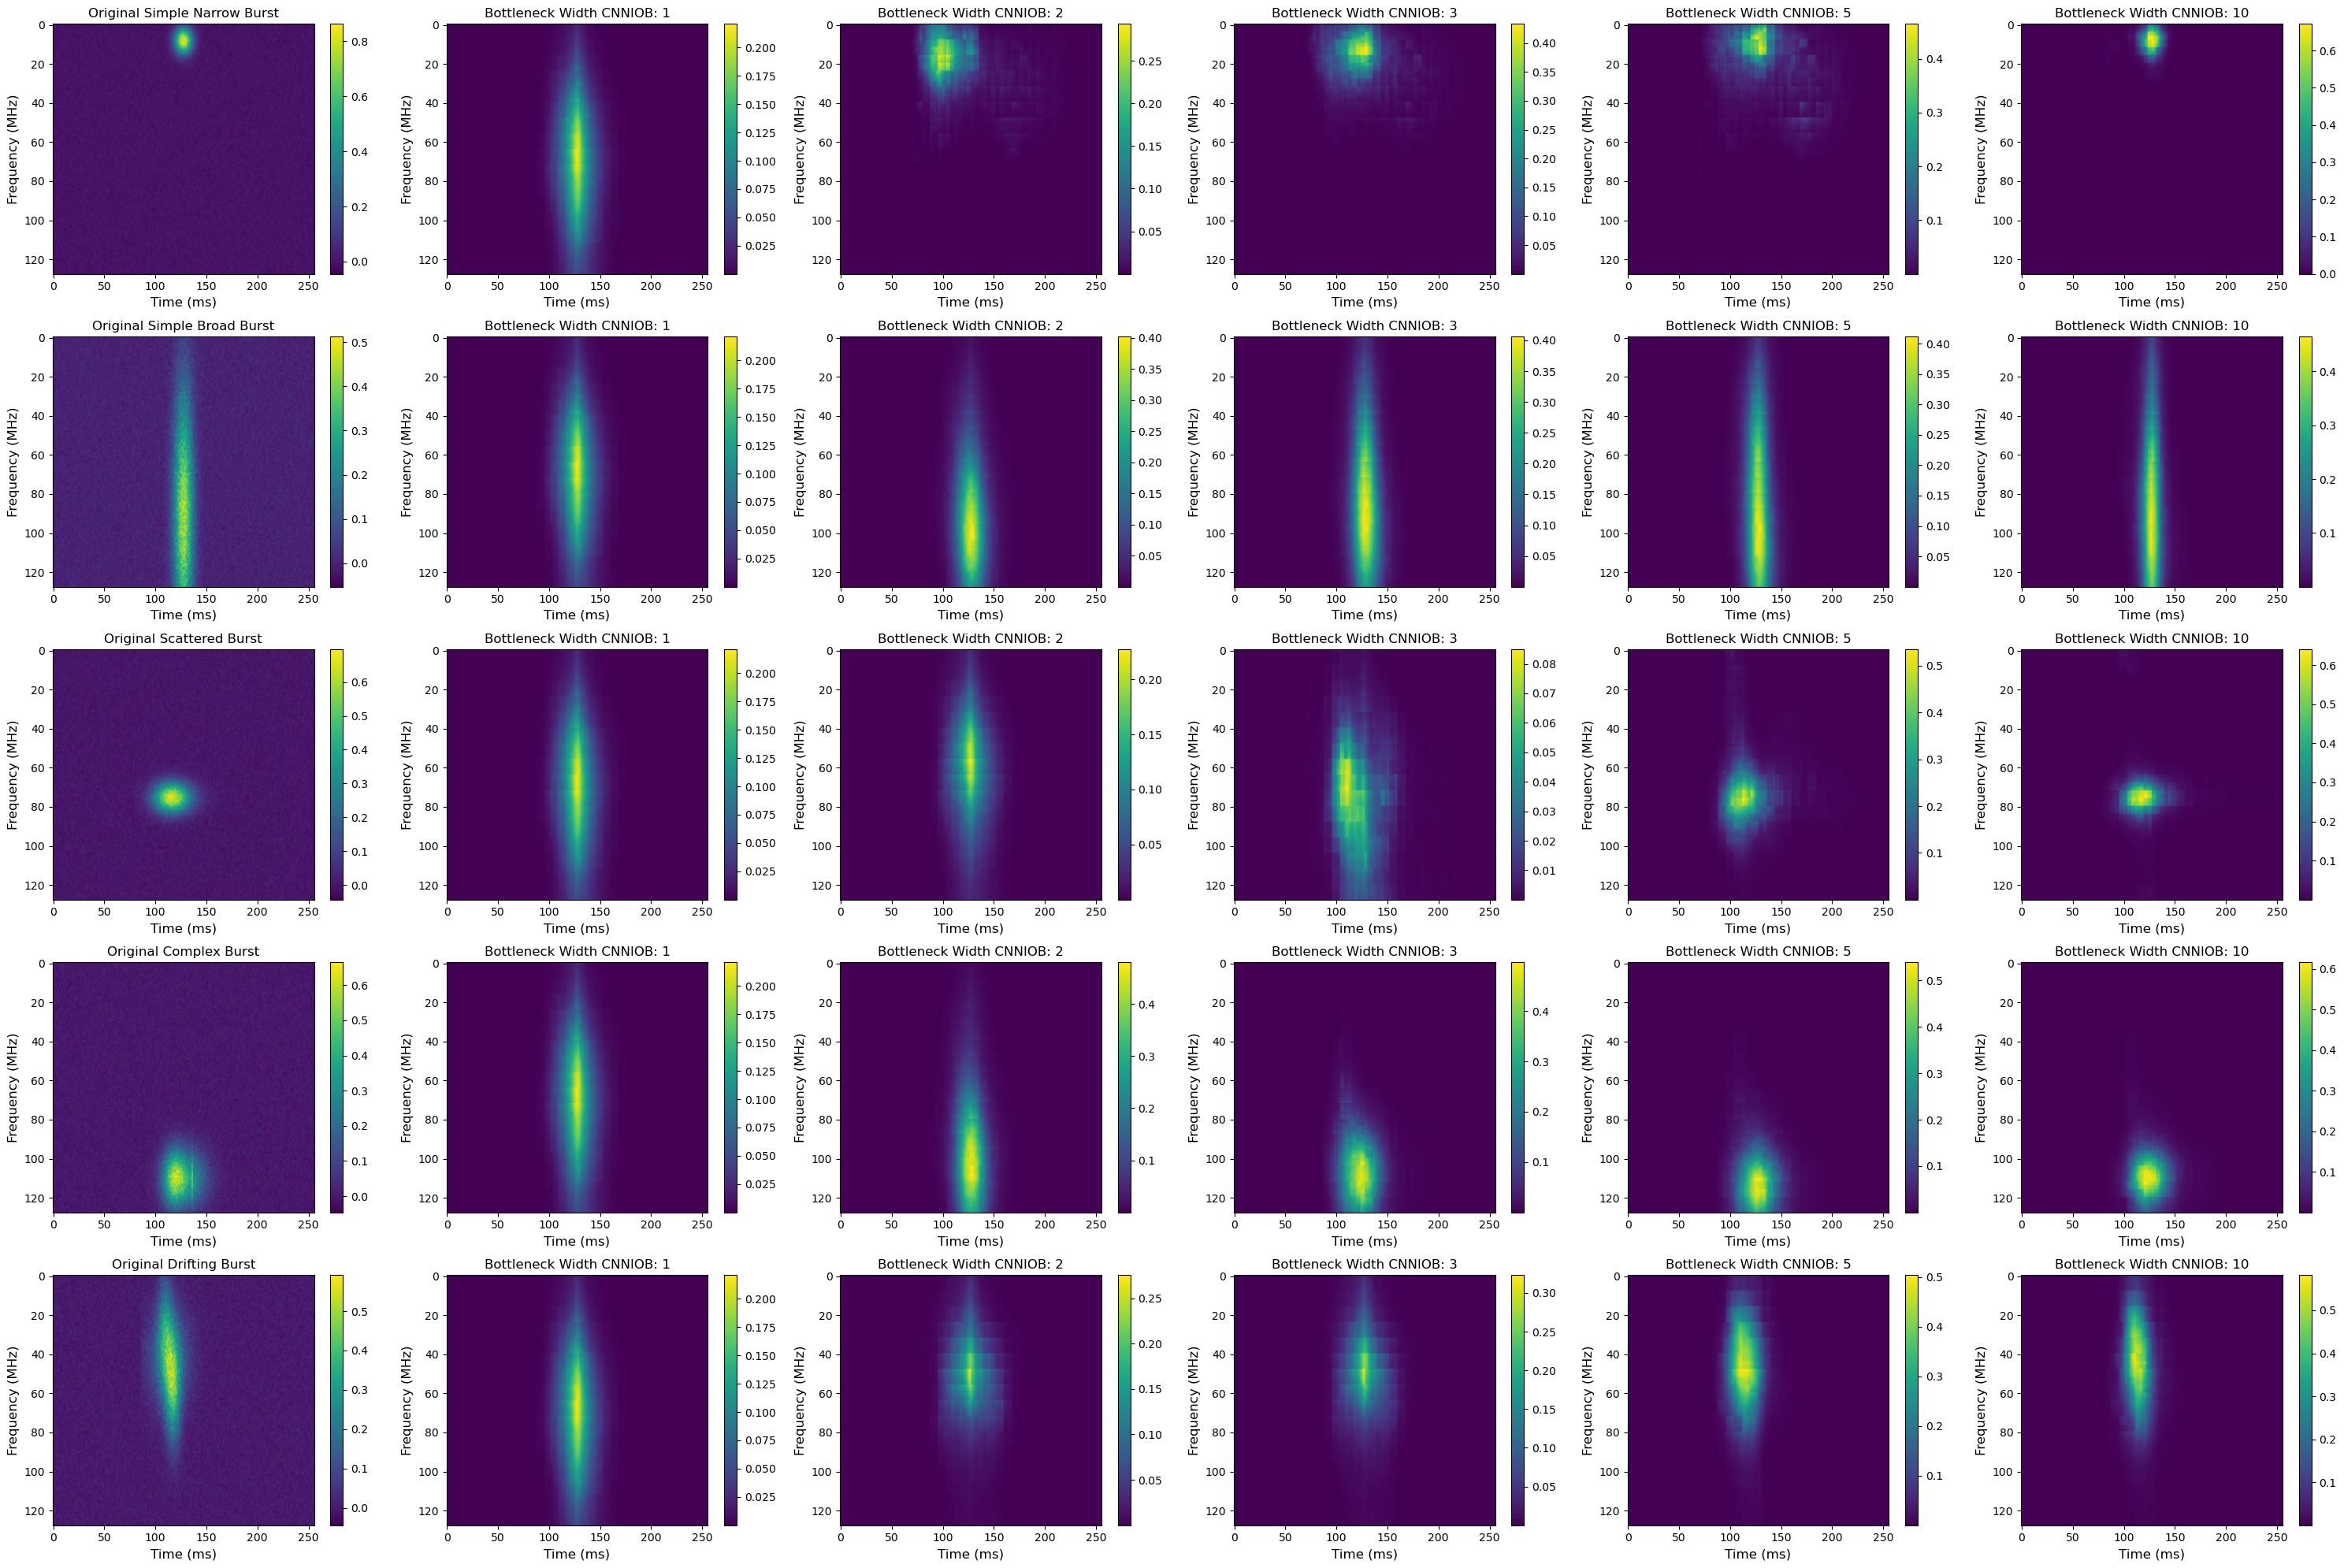

In [110]:
import random

# Initialize a list to store burst categories
burst_categories = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

# Initialize a dictionary to store burst indices for each category
burst_indices_by_category = {category: [] for category in burst_categories}

# Iterate over labels_test to populate burst_indices_by_category
for idx, label in enumerate(labels_test):
    category = burst_categories[label]
    burst_indices_by_category[category].append(idx)

# Select a random burst index for each category
selected_burst_indices = {category: random.choice(indices) for category, indices in burst_indices_by_category.items()}

# Initialize a list to store the selected bottleneck widths
selected_widths = [1, 2, 3, 5, 10]  # Example: Selecting 5 bottleneck widths

# Create subplots for original and reconstructed bursts
plt.figure(figsize=(30, 20))

# Iterate over burst categories
for i, category in enumerate(burst_categories):
    # Retrieve the original burst for the current category
    burst_idx = selected_burst_indices[category]
    original_burst = data_test[burst_idx].squeeze()
    
    # Plot the original burst
    plt.subplot(len(burst_categories), len(selected_widths) + 1, i * (len(selected_widths) + 1) + 1)
    plt.imshow(original_burst.T, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f"Original {category} Burst")
    plt.xlabel("Time (ms)", size=12)
    plt.ylabel("Frequency (MHz)", size=12)

    # Iterate over the selected bottleneck widths
    for j, width in enumerate(selected_widths):
        # Select the reconstructed data for the current bottleneck width
        reconstructed = reconstructed_all[burst_idx, width - 1].squeeze()

        # Plot the reconstructed burst
        plt.subplot(len(burst_categories), len(selected_widths) + 1, i * (len(selected_widths) + 1) + j + 2)
        plt.imshow(reconstructed.T, aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.title(f"Bottleneck Width CNNIOB: {width}")
        plt.xlabel("Time (ms)", size=12)
        plt.ylabel("Frequency (MHz)", size=12)

plt.tight_layout()
plt.show()



/tmp/ipykernel_1963471/1409837127.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(latent_data_1, latent_data_2, cmap='viridis', marker='o')


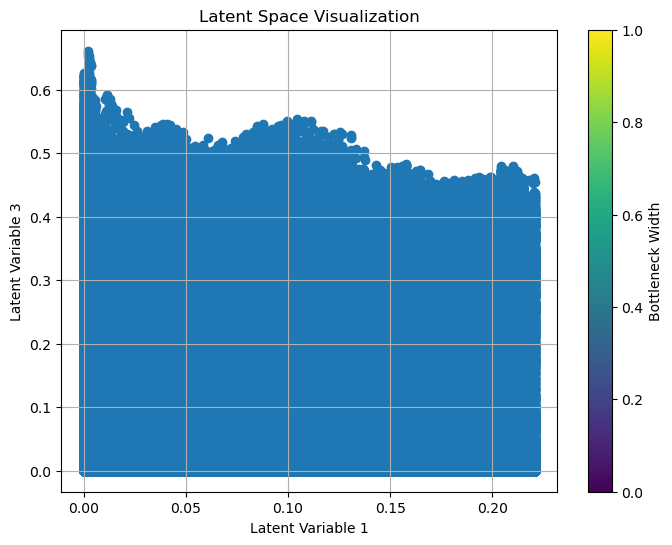

In [83]:
# Select the dimensions to visualize
latent_variable_1 = 0  # Latent variable 1
latent_variable_2 = 2  # Latent variable 2

# Extract the selected latent variables from the reconstructed data
latent_data_1 = reconstructed_all[:, latent_variable_1]
latent_data_2 = reconstructed_all[:, latent_variable_2]

# Plot latent variable 1 against latent variable 2
plt.figure(figsize=(8, 6))
plt.scatter(latent_data_1, latent_data_2, cmap='viridis', marker='o')
plt.colorbar(label='Bottleneck Width')
plt.title('Latent Space Visualization')
plt.xlabel(f'Latent Variable {latent_variable_1+1}')
plt.ylabel(f'Latent Variable {latent_variable_2+1}')
plt.grid(True)
plt.show()